In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import os.path
from mlxtend.preprocessing import minmax_scaling
from colorama import Fore, Back, Style
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from plotly.subplots import make_subplots

In [4]:
def move_row(df, from_idx, to_idx):
    current_order = list(df.index)
    row_to_move = current_order.pop(from_idx)
    current_order.insert(to_idx, row_to_move)
    df = df.reindex(current_order).reset_index(drop=True)
    
    return df

In [68]:
def percentage_change(base, new):
    try:
        change = (((new - base) / base) * 100)
        return round(abs(change),2)
    except ZeroDivisionError:
        return float('inf')


# Process dataset

SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [157]:
data_path ='./New/AudioMNIST/VGGishMel/UNLEARN/Item_Removal/7200/'
dict_path = data_path+"44/unlearning_results.json"
csv_path = data_path+"/dis_results.json"

with open(dict_path, "r") as json_file:
    data = json.load(json_file)

dict1 = data['40']
dict2 = data['41']
dict3 = data['42']
dict4 = data['43']
dict5 = data['44']

result_dict = {}
for key in dict1:
    result_dict[key] = {}
    for inner_key in dict1[key]:
        array = []
        acc = []
        array.append(dict1[key][inner_key])
        array.append(dict2[key][inner_key])
        array.append(dict3[key][inner_key])
        array.append(dict4[key][inner_key])
        array.append(dict5[key][inner_key])

        if inner_key ==  'Forget accuracy':
            ua = [100 - array[i] for i in range(len(array))]
            result_dict[key]['ua'] = []
            result_dict[key]['ua'].append(round(np.mean(ua),2))
            result_dict[key]['ua'].append(round(np.std(ua),2))
        if inner_key ==  'Impair Time':
            time_impair = array
        if inner_key ==  'Repair Time':
            time_repair = array
            time = [time_impair[i] + time_repair[i] for i in range(len(time_impair))]
            result_dict[key]['RTE'] = []
            result_dict[key]['RTE'].append(round(np.mean(time),2))
            result_dict[key]['RTE'].append(round(np.std(time),2))
        if inner_key == 'Activation distance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 10 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))
        if inner_key == 'JS divergance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 1000 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

        else:
            result_dict[key][f'{inner_key}'] = []
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

list_of_dicts = []
for key, values in result_dict.items():
    if key =='Original Model':
        continue
    else:
        row_dict = {'Method': key}
        for value in values.items():
            if value[0] == "Remain accuracy":
                row_dict['RA'] = value[1]
            if value[0] == "Test accuracy":
                row_dict['TA'] =value[1]
            if value[0] == "ua":
                row_dict['UA'] =value[1]
            if value[0] == "RTE":
                if key =='Stochastic Teacher Unlearning':
                    rte = []
                    
                    rte.append(round(value[1][0]/10,2))
                    rte.append(round(value[1][1]/10,2))
                    row_dict['RTE'] = rte
                else:
                    row_dict['RTE'] =value[1]
            if value[0] == "Activation distance":
                row_dict['Activation distance'] =value[1]
            if value[0] == "JS divergance":
                row_dict['JS divergance'] =value[1]
            if value[0] == "Loss MIA":
                row_dict['MIA efficay'] =value[1]
        list_of_dicts.append(row_dict)
df = pd.DataFrame(list_of_dicts)

ua = df.iloc[0]['UA'][0]
mia = df.iloc[0]['MIA efficay'][0]
ra = df.iloc[0]['RA'][0]
ta = df.iloc[0]['TA'][0]

df['Disparity AVE'] = None

for i,row in df.iterrows():
    diff =0 
    ua_dis  = round((((row['UA'][0])-ua)),2)
    row['UA'] = row['UA'].append(ua_dis)
    mia_dis = round((((row['MIA efficay'][0]))-mia),2)
    row['MIA efficay'] = row['MIA efficay'].append(mia_dis)
    ra_dis =  round((((row['RA'][0])-ra)),2)
    row['RA'] = row['RA'].append(ra_dis)
    ta_dis = round((((row['TA'][0])-ta)),2)
    row['TA'] = row['TA'].append(ta_dis)
    diff =  round((ua_dis+mia_dis+ra_dis+ta_dis)/4,2)
    df.at[i, 'Disparity AVE'] = diff

df = df[['Method','UA','MIA efficay','RA','TA','Disparity AVE','Activation distance','JS divergance','RTE']]
method_names = ['Niave','GA','FT','ST','OMP','CS','POP','AM','LS']
for i in range(len(method_names)):
    df.at[i ,'Method'] = method_names[i]

df =  move_row(df,7,5)
df = move_row(df,8,6)

time = df['RTE'][0][0]

for x in df.iterrows():
    x[1]['RTE'] = percentage_change(time, x[1]['RTE'][0])


df

,Method,UA,MIA efficay,RA,TA,Disparity AVE,Activation distance,JS divergance,RTE
0,Niave,"[1.38, 0.16, 0.0]","[100.0, 0.0, 0.0]","[99.52, 0.18, 0.0]","[98.82, 0.13, 0.0]",0.0,"[0.0, 0.0]","[0.0, 0.0]",0.0
1,GA,"[0.31, 0.11, -1.07]","[100.0, 0.0, 0.0]","[99.78, 0.06, 0.26]","[99.05, 0.09, 0.23]",-0.15,"[0.21, 0.02]","[0.45, 0.05]",88.41
2,FT,"[3.84, 7.02, 2.46]","[100.0, 0.0, 0.0]","[96.22, 7.17, -3.3]","[95.52, 7.04, -3.3]",-1.03,"[0.92, 1.42]","[2.56, 4.29]",89.49
3,ST,"[40.59, 25.13, 39.21]","[100.0, 0.0, 0.0]","[60.14, 25.24, -39.38]","[59.94, 25.47, -38.88]",-9.76,"[5.62, 1.95]","[21.06, 13.13]",44.45
4,OMP,"[3.74, 1.07, 2.36]","[100.0, 0.0, 0.0]","[96.32, 1.02, -3.2]","[95.99, 0.98, -2.83]",-0.92,"[0.87, 0.25]","[1.61, 0.57]",88.99
5,AM,"[2.77, 0.79, 1.39]","[100.0, 0.0, 0.0]","[97.47, 0.75, -2.05]","[97.09, 0.62, -1.73]",-0.6,"[0.63, 0.17]","[1.08, 0.37]",88.78
6,LS,"[1.95, 0.39, 0.57]","[100.0, 0.0, 0.0]","[98.28, 0.4, -1.24]","[97.67, 0.45, -1.15]",-0.45,"[0.4, 0.08]","[0.64, 0.15]",88.51
7,CS,"[0.46, 0.18, -0.92]","[100.0, 0.0, 0.0]","[99.71, 0.15, 0.19]","[99.01, 0.15, 0.19]",-0.14,"[0.2, 0.03]","[0.38, 0.05]",82.2
8,POP,"[1.22, 0.22, -0.16]","[100.0, 0.0, 0.0]","[98.91, 0.27, -0.61]","[98.32, 0.25, -0.5]",-0.32,"[0.26, 0.04]","[0.39, 0.08]",82.45


In [158]:
df.to_json(csv_path,index =False)

# Create Tabel CSVs

SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [178]:
removal = 7150
save_path = './New/AudioMNIST/Data/Class/'

In [179]:
data_path_1 =f'./New/AudioMNIST/VGGishMel/UNLEARN/Class_Removal/{removal}'
data_path_2 =f'./New/AudioMNIST/CTCmel/UNLEARN/Class_Removal/{removal}'
data_path_3 =f'./New/AudioMNIST/ViTmel/UNLEARN/Class_Removal/{removal}'
csv_path_vggish = pd.read_json(data_path_1+"/dis_results.json")
csv_path_ctc = pd.read_json(data_path_2+"/dis_results.json")
csv_path_vit = pd.read_json(data_path_3+"/dis_results.json")
df = pd.concat([csv_path_vggish,csv_path_ctc,csv_path_vit],ignore_index=True)
df.to_csv((save_path+f'dis_{removal}.csv'),index=False)
df.to_json((save_path +f'dis_{removal}.json'),index=False)



# Correlation plots

SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [113]:
path ='./New/SpeechCommands/Data/Item/'
data_1 = pd.read_json((path+'dis_8485.json'))
data_2 = pd.read_json((path+'dis_16969.json'))
data_3 = pd.read_json((path+'dis_25453.json'))
corr_df = pd.concat([data_1,data_2,data_3],ignore_index=True)

/var/folders/xz/sg0mwr3x33d61npvhs79g48r0000gq/T/ipykernel_19133/620199262.py:2: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/xz/sg0mwr3x33d61npvhs79g48r0000gq/T/ipykernel_19133/620199262.py:2: SettingWithCopyWarning:


A value

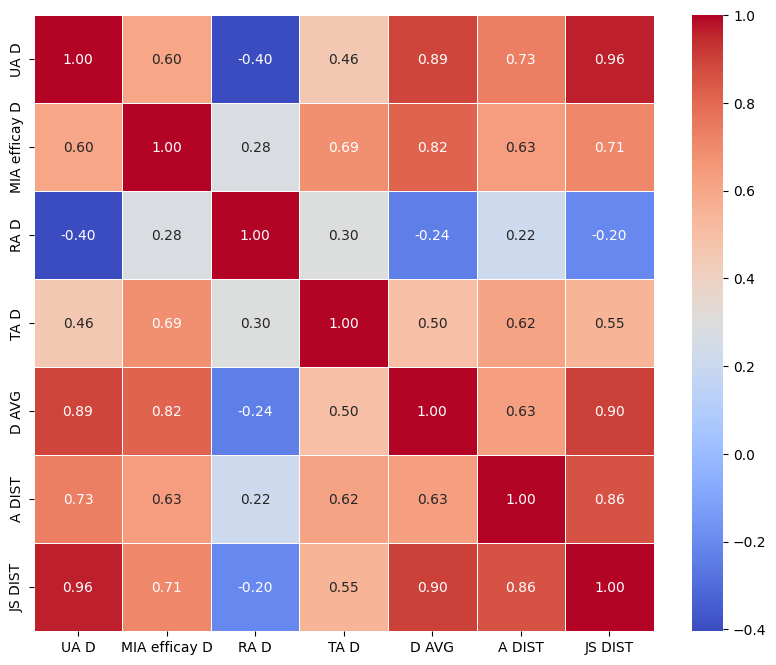

In [114]:
for i in range(len(corr_df)):
    corr_df['UA'][i] = abs(corr_df['UA'][i][2])
    corr_df['MIA efficay'][i] = abs(corr_df['MIA efficay'][i][2])
    corr_df['RA'][i] = abs(corr_df['RA'][i][2])
    corr_df['TA'][i] = abs(corr_df['TA'][i][2])
    corr_df['Activation distance'][i] = corr_df['Activation distance'][i][0]
    corr_df['JS divergance'][i] = corr_df['JS divergance'][i][0]

corr_df['Disparity AVE'] = abs(corr_df['Disparity AVE'])
corr_df = corr_df.drop(['Method','RTE'],axis=1)
corr_df
corr_df.rename(columns={'Activation distance': 'A DIST'}, inplace=True)
corr_df.rename(columns={'Disparity AVE': 'D AVG'}, inplace=True)
corr_df.rename(columns={'JS divergance': 'JS DIST'}, inplace=True)
corr_df.rename(columns={'UA': 'UA D'}, inplace=True)
corr_df.rename(columns={'MIA efficay': 'MIA efficay D'}, inplace=True)
corr_df.rename(columns={'RA': 'RA D'}, inplace=True)
corr_df.rename(columns={'TA': 'TA D'}, inplace=True)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.savefig((path+'dis_corr_Item.pdf'), format='pdf') 
plt.show()


# Radar figures

In [81]:
def get_disparity(df):
    df_radar = pd.DataFrame()
    df_radar['UA'] = None
    df_radar['MIA efficay'] = None
    df_radar['RA'] = None
    df_radar['TA'] = None
    df_radar['RTE'] = None

    for i,row in df.iterrows():
        diff =0 
        df_radar.at[i, 'UA'] = row['UA'][2]
        df_radar.at[i, 'MIA efficay'] = row['MIA efficay'][2]
        df_radar.at[i, 'RA'] = row['RA'][2]
        df_radar.at[i, 'TA'] = row['TA'][2]        
        df_radar.at[i, 'RTE'] = row['RTE']
    return df_radar

def radar_array(x):
    radar_arr = []
    for index, value in x.iterrows():
        radar_arr.append(x.iloc[index].values)
    return radar_arr

def get_categories(df):
    categories = [f'UA',f'MIA Efficay',f'RA',f'TA']
    return categories


SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [110]:
path = './New/AudioMNIST/'
removal = '/UNLEARN/Item_Removal/2400'

In [111]:
data_path_1 =f'{path}VGGishMel{removal}'
data_path_2 =f'{path}/CTCmel{removal}'
data_path_3 =f'{path}/ViTmel{removal}'
results_path_1 = data_path_1 + '/dis_results.json'
results_path_2 = data_path_2 + '/dis_results.json'
results_path_3 = data_path_3 + '/dis_results.json'
df_1 = pd.read_json(results_path_1)
df_2 = pd.read_json(results_path_2)
df_3 = pd.read_json(results_path_3)
radar_1 = get_disparity(df_1)
radar_2 = get_disparity(df_2)
radar_3 = get_disparity(df_3)
x_1 = minmax_scaling(radar_1, columns=['UA', 'MIA efficay','RA','TA','RTE'])
x_1['MIA efficay'] = 1.0
x_2 = minmax_scaling(radar_2, columns=['UA', 'MIA efficay','RA','TA','RTE'])
x_3 = minmax_scaling(radar_3, columns=['UA', 'MIA efficay','RA','TA','RTE'])
radar_arr_1 = radar_array(x_1)
radar_arr_2 = radar_array(x_2)
radar_arr_3 = radar_array(x_3)

In [112]:
categories_1 = get_categories(df_1)
categories_2 = get_categories(df_2)
categories_3 = get_categories(df_3)


fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'}]*3],vertical_spacing=0.005,horizontal_spacing=0.04)

fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[0][0],radar_arr_1[0][1],radar_arr_1[0][2],radar_arr_1[0][3]],
      theta=categories_1,
      fill = 'toself',
      marker=dict(size=5, color='rgba(104,172, 229, 0.1)'),
      name=f'Naive'
),row=1, col=1)

fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[1][0],radar_arr_1[1][1],radar_arr_1[1][2],radar_arr_1[1][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='red'),
      name=f'GA'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[2][0],radar_arr_1[2][1],radar_arr_1[2][2],radar_arr_1[2][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='#FFD100'),
      name='FT'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[3][0],radar_arr_1[3][1],radar_arr_1[3][2],radar_arr_1[3][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='orange'),
      name='ST'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[4][0],radar_arr_1[4][1],radar_arr_1[4][2],radar_arr_1[4][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='brown'),
      name='OMP'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[5][0],radar_arr_1[5][1],radar_arr_1[5][2],radar_arr_1[5][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='purple'),
      name='AM'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[6][0],radar_arr_1[6][1],radar_arr_1[6][2],radar_arr_1[6][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='DarkKhaki'),
      name='LS'
))
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[7][0],radar_arr_1[7][1],radar_arr_1[7][2],radar_arr_1[7][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='pink'),
      name='CS'
),row=1, col=1)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_1[8][0],radar_arr_1[8][1],radar_arr_1[8][2],radar_arr_1[8][3]],
      theta=categories_1,
      fill = 'none',
      marker=dict(size=5, color='grey'),
      name='POP',
),row=1, col=1)


fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[0][0],radar_arr_2[0][1],radar_arr_2[0][2],radar_arr_2[0][3]],
      showlegend=False,
      theta= categories_2,
      fill = 'toself',
      marker=dict(size=5, color='rgba(104,172, 229, 0.1)'),
),row=1, col=2)

fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[1][0],radar_arr_2[1][1],radar_arr_2[1][2],radar_arr_2[1][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='red'),
      fill = 'none'
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[2][0],radar_arr_2[2][1],radar_arr_2[2][2],radar_arr_2[2][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='#FFD100'),
      fill = 'none'
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[3][0],radar_arr_2[3][1],radar_arr_2[3][2],radar_arr_2[3][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='orange'),
      fill = 'none'
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[4][0],radar_arr_2[4][1],radar_arr_2[4][2],radar_arr_2[4][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='brown'),
      fill = 'none'
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[5][0],radar_arr_2[5][1],radar_arr_2[5][2],radar_arr_2[5][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='purple'),
      fill = 'none',
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[6][0],radar_arr_2[6][1],radar_arr_2[6][2],radar_arr_2[6][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='DarkKhaki'),
      fill = 'none',
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[7][0],radar_arr_2[7][1],radar_arr_2[7][2],radar_arr_2[7][3]],
      theta=categories_2,
      showlegend=False,
      marker=dict(size=5, color='pink'),
      fill = 'none',
),row=1, col=2)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_2[8][0],radar_arr_2[8][1],radar_arr_2[8][2],radar_arr_2[8][3]],
      theta=categories_2,
      marker=dict(size=5, color='grey'),
      showlegend=False,
      fill = 'none',
),row=1, col=2)



fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[0][0],radar_arr_3[0][1],radar_arr_3[0][2],radar_arr_3[0][3]],
      showlegend=False,
      theta=categories_3,
      fill = 'toself',
      marker=dict(size=5, color='rgba(104,172, 229, 0.1)'),
),row=1, col=3)

fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[1][0],radar_arr_3[1][1],radar_arr_3[1][2],radar_arr_3[1][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='red'),
      fill = 'none'
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[2][0],radar_arr_3[2][1],radar_arr_3[2][2],radar_arr_3[2][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='#FFD100'),
      fill = 'none'
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[3][0],radar_arr_3[3][1],radar_arr_3[3][2],radar_arr_3[3][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='orange'),
      fill = 'none'
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[4][0],radar_arr_3[4][1],radar_arr_3[4][2],radar_arr_3[4][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='brown'),
      fill = 'none'
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[5][0],radar_arr_3[5][1],radar_arr_3[5][2],radar_arr_3[5][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='purple'),
      fill = 'none',
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[6][0],radar_arr_3[6][1],radar_arr_3[6][2],radar_arr_3[6][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='DarkKhaki'),
      fill = 'none',
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[7][0],radar_arr_3[7][1],radar_arr_3[7][2],radar_arr_3[7][3]],
      theta=categories_3,
      showlegend=False,
      marker=dict(size=5, color='pink'),
      fill = 'none',
),row=1, col=3)
fig.add_trace(go.Scatterpolar(
      r=[radar_arr_3[8][0],radar_arr_3[8][1],radar_arr_3[8][2],radar_arr_3[8][3]],
      theta=categories_3,
      marker=dict(size=5, color='grey'),
      showlegend=False,
      fill = 'none',
),row=1, col=3)
	
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            range=(0,1),
        ),
    ),
    polar2=dict(
        radialaxis=dict(
            range=(0,1),
        ),
    ),
    polar3=dict(
        radialaxis=dict(
            range=(0,1),
        ),
    ),
    legend=dict(
        x=1.1, 
    ),
    width=1500, 
    height=600,  
)
fig.update_layout(
    margin=dict(l=30, r=0, t=0, b=0), 
    autosize=True                 
)
fig.write_image((data_path_3+'/R_10_radar_graph.pdf'))
fig.show()


# Loss change figures

In [216]:
def plot_historgram_plotly(fig,df1,df2,df3,method_row,method_colour,row,col):
    fig.add_trace(go.Histogram(
        x=df1['0'].to_numpy(),
        name='Naive',
        nbinsx= 100,
        opacity=0.5,
        showlegend=False,
        marker=dict(color='#68ACE5')
    ),row =row,col =col)

    fig.add_trace(go.Histogram(
        x=df2['0'].to_numpy(),
        name=method_row,
        nbinsx= 100,
        opacity=0.5,
        marker=dict(color=method_colour)
    ),row =row,col =col)

    fig.add_trace(go.Histogram(
        x=df3['0'].to_numpy(),
        name='Original',
        nbinsx= 100,
        opacity=1,
        showlegend=False,
        marker=dict(color='#55A51C')
    ),row =row,col =col)


In [217]:
def remove_outliers(df):
    mean_label_0 = df[df['label'] == 0]['0'].mean()
    std_label_0 = df[df['label'] == 0]['0'].std()

    mean_label_1 = df[df['label'] == 1]['0'].mean()
    std_label_1 = df[df['label'] == 1]['0'].std()

    df_no_outliers = pd.concat([
        df[(df['label'] == 0) & (np.abs(df['0'] - mean_label_0) <= 3 * std_label_0)],
        df[(df['label'] == 1) & (np.abs(df['0'] - mean_label_1) <= 3 * std_label_1)]
    ])
    return df_no_outliers 

def process_loss(path):
    df = pd.read_csv(path)
    df = remove_outliers(df)
    df = df.drop(['label'],axis =1)
    return df

SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [230]:
dir = './New/AudioMNIST/VGGishMel/UNLEARN/Class_Removal/2372/'
loss_path = dir+ '/42/'
class_img = dir + 'C1_VGG.pdf'
# random_img = dir + '30_ViT.pdf'

df_forget_niave = process_loss(loss_path+'naive_model_loss_forget.csv')
df_forget_ga = process_loss(loss_path+'gradient_ascent_model_loss_forget.csv')
df_forget_ft = process_loss(loss_path+'fine_tuning_model_loss_forget.csv')
df_forget_og =  process_loss(loss_path+'orginal_model_loss_forget.csv')
df_forget_CS = process_loss(loss_path+'cosine_model_loss_forget.csv')
df_forget_ST = process_loss(loss_path+'stochastic_teacher_model_loss_forget.csv')
df_forget_AM = process_loss(loss_path+'randl_model_loss_forget.csv')
df_forget_LS = process_loss(loss_path+'randl_model_loss_forget.csv')
df_forget_OMP = process_loss(loss_path+'omp_model_loss_forget.csv')
df_forget_POP = process_loss(loss_path+'kk_model_loss_forget.csv')

In [231]:
fig = make_subplots(rows=2, cols=4,horizontal_spacing=0.05,x_title='Loss', y_title='Frequency')

fig.add_trace(go.Histogram(
    x=df_forget_niave['0'].to_numpy(),
    name='Naive',
    nbinsx= 100,
    opacity=0.5,
    marker=dict(color='#68ACE5')
),row =1,col =1)


fig.add_trace(go.Histogram(
    x=df_forget_ga['0'].to_numpy(),
    name='GA',
    nbinsx= 100,
    opacity=0.5,
    marker=dict(color='red')
),row =1,col =1)

fig.add_trace(go.Histogram(
    x=df_forget_og['0'].to_numpy(),
    name='Original',
    nbinsx= 100,
    opacity=1,
    marker=dict(color='#55A51C')
),row =1,col =1)

plot_historgram_plotly(fig,df_forget_niave,df_forget_ft,df_forget_og,' FT','#FFD100',1,2)
plot_historgram_plotly(fig,df_forget_niave,df_forget_ST,df_forget_og,' ST','orange',1,3)
plot_historgram_plotly(fig,df_forget_niave,df_forget_OMP,df_forget_og,' OMP','brown',1,4)
plot_historgram_plotly(fig,df_forget_niave,df_forget_AM,df_forget_og,' AM','purple',2,1)
plot_historgram_plotly(fig,df_forget_niave,df_forget_LS,df_forget_og,'LS','DarkKhaki',2,2)
plot_historgram_plotly(fig,df_forget_niave,df_forget_CS,df_forget_og,'CS','pink',2,3)
plot_historgram_plotly(fig,df_forget_niave,df_forget_POP,df_forget_og,'POP','grey',2,4)

fig.update_layout(
    barmode='overlay',
    bargap=0.00001, 
    width=900, 
    height=500, 
)
fig.update_xaxes(range=[0, np.max(df_forget_niave['0'].to_numpy())])
fig.update_yaxes(type="log")
fig.update_yaxes(
    tickvals=[10**i for i in range(10)],
)
fig.write_image(class_img)
fig.show()


# Scalling plots

In [38]:
def split_df(df):
    df_vgg = df.iloc[0:9]
    df_ctc = df.iloc[9:18]
    df_ctc.reset_index(drop=True, inplace = True)
    df_vit = df.iloc[18:27]
    df_vit.reset_index(drop=True,inplace = True)
    return df_vgg,df_ctc,df_vit


In [39]:
def plot_scalling(fig,x,naive_method,ga,ft,st,omp,am,ls,cs,pop,row,column):
    fig.add_trace(go.Scatter(
    x=x,
    y=naive_method,
    mode='lines+markers',
    name='Naive',
    line = dict(dash='dash'),
    showlegend=False,
    marker=dict(size=11,color='#68ACE5')
    ),row=row, col=column)


    fig.add_trace(go.Scatter(
    x=x,
    y=ga,
    mode='lines+markers',
    name='GA',
    showlegend=False,
    line=dict(color='red')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=ft,
        mode='lines+markers',
        name='FT',
        showlegend=False,
        line=dict(color='#FFD100')
    ),row=row, col=column)

    # Third trace
    fig.add_trace(go.Scatter(
        x=x,
        y=st,
        mode='lines+markers',
        name='ST',
        showlegend=False,
        line=dict(color='orange')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=omp,
        mode='lines+markers',
        name='OMP',
        showlegend=False,
        line=dict(color='brown')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=am,
        mode='lines+markers',
        name='AM',
        showlegend=False,
        line=dict(color='purple')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=ls,
        mode='lines+markers',
        name='LS',
        showlegend=False,
        line=dict(color='DarkKhaki')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=cs,
        mode='lines+markers',
        name='CS',
        showlegend=False,
        line=dict(color='pink')
    ),row=row, col=column)

    fig.add_trace(go.Scatter(
        x=x,
        y=pop,
        mode='lines+markers',
        name='POP',
        showlegend=False,
        line=dict(color='grey')
    ),row=row, col=column)


In [40]:
def scalling_arr(df,df2,df3,column):
    if column == 'UA' or column == 'MIA efficay' or column == 'RA' or column ==  'TA':
        ga = [df[column][1][2],df2[column][1][2],df3[column][1][2]]
        ft = [df[column][2][2],df2[column][2][2],df3[column][2][2]]
        st = [df[column][3][2],df2[column][3][2],df3[column][3][2]]
        omp = [df[column][4][2],df2[column][4][2],df3[column][4][2]]
        am = [df[column][5][2],df2[column][5][2],df3[column][5][2]]
        ls = [df[column][6][2],df2[column][6][2],df3[column][6][2]]
        cs = [df[column][7][2],df2[column][7][2],df3[column][7][2]]
        pop = [df[column][8][2],df2[column][8][2],df3[column][8][2]]
    elif column == 'Disparity AVE':
        ga = [df[column][1],df2[column][1],df3[column][1]]
        ft = [df[column][2],df2[column][2],df3[column][2]]
        st = [df[column][3],df2[column][3],df3[column][3]]
        omp = [df[column][4],df2[column][4],df3[column][4]]
        am = [df[column][5],df2[column][5],df3[column][5]]
        ls = [df[column][6],df2[column][6],df3[column][6]]
        cs = [df[column][7],df2[column][7],df3[column][7]]
        pop = [df[column][8],df2[column][8],df3[column][8]]
    elif column == 'Activation distance' or 'JS divergance':
        ga = [df[column][1][0],df2[column][1][0],df3[column][1][0]]
        ft = [df[column][2][0],df2[column][2][0],df3[column][2][0]]
        st = [df[column][3][0],df2[column][3][0],df3[column][3][0]]
        omp = [df[column][4][0],df2[column][4][0],df3[column][4][0]]
        am = [df[column][5][0],df2[column][5][0],df3[column][5][0]]
        ls = [df[column][6][0],df2[column][6][0],df3[column][6][0]]
        cs = [df[column][7][0],df2[column][7][0],df3[column][7][0]]
        pop = [df[column][8][0],df2[column][8][0],df3[column][8][0]]
    return  ga,ft,st,omp,am,ls,cs,pop

    

In [ ]:
SpeechCommands

8485,16969,25453

3240,4834,8004

audioMNIST

2400,4800,7200

2372,4745,7150

In [62]:
path ='./New/AudioMNIST/Data/Item/'
data_1 = pd.read_json((path+'dis_2400.json'))
df_vgg_1,df_ctc_1,df_vit_1 = split_df(data_1)
data_2 = pd.read_json((path+'dis_4800.json'))
df_vgg_2,df_ctc_2,df_vit_2 = split_df(data_2)
data_3 = pd.read_json((path+'dis_7200.json'))
df_vgg_3,df_ctc_3,df_vit_3 = split_df(data_3)

In [67]:
column = 'UA'
ga,ft,st,omp,am,ls,cs,pop = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)
column = 'MIA efficay'
ga_1,ft_1,st_1,omp_1,am_1,ls_1,cs_1,pop_1 = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)
column = 'RA'
ga_2,ft_2,st_2,omp_2,am_2,ls_2,cs_2,pop_2 = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)
column = 'TA'
ga_3,ft_3,st_3,omp_3,am_3,ls_3,cs_3,pop_3 = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)
column = 'Activation distance'
ga_5,ft_5,st_5,omp_5,am_5,ls_5,cs_5,pop_5 = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)
column = 'JS divergance'
ga_6,ft_6,st_6,omp_6,am_6,ls_6,cs_6,pop_6 = scalling_arr(df_vit_1,df_vit_2,df_vit_3,column)

In [68]:
x = [10, 20, 30]
naive_method = [0.0,0.0,0.0]

fig = make_subplots(rows=2, cols=3,subplot_titles=('UA', 'MIA Efficay', 'RA','TA','A DIST','JS DIST'),vertical_spacing=0.06,horizontal_spacing=0.05,x_title='Percentage of Items Removed', y_title='Metric Disparity')

fig.add_trace(go.Scatter(
    x=x,
    y=naive_method,
    mode='lines+markers',
    name='Naive',
    line = dict(dash='dash'),
    marker=dict(size=11,color='#68ACE5')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=ga,
    mode='lines+markers',
    name='GA',
    line=dict(color='red')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=ft,
    mode='lines+markers',
    name='FT',
    line=dict(color='#FFD100')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=st,
    mode='lines+markers',
    name='ST',
    line=dict(color='orange')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=omp,
    mode='lines+markers',
    name='OMP',
    line=dict(color='brown')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=am,
    mode='lines+markers',
    name='AM',
    line=dict(color='purple')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=ls,
    mode='lines+markers',
    name='LS',
    line=dict(color='DarkKhaki')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=cs,
    mode='lines+markers',
    name='CS',
    line=dict(color='pink')
),row=1, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=pop,
    mode='lines+markers',
    name='POP',
    line=dict(color='grey')
),row=1, col=1)

fig.update_layout(
    showlegend=True,
    width=900, 
    height=900, 
)
plot_scalling(fig,x,naive_method,ga_1,ft_1,st_1,omp_1,am_1,ls_1,cs_1,pop_1,1,2)
plot_scalling(fig,x,naive_method,ga_2,ft_2,st_2,omp_2,am_2,ls_2,cs_2,pop_2,1,3)
plot_scalling(fig,x,naive_method,ga_3,ft_3,st_3,omp_3,am_3,ls_3,cs_3,pop_3,2,1)
plot_scalling(fig,x,naive_method,ga_5,ft_5,st_5,omp_5,am_5,ls_5,cs_5,pop_5,2,2)
plot_scalling(fig,x,naive_method,ga_6,ft_6,st_6,omp_6,am_6,ls_6,cs_6,pop_6,2,3)
fig.write_image((path+'Item_ViT_scalling.pdf'))
fig.show()


In [3]:

def smooth_labels(labels, factor=0.95):
    labels = labels.astype(np.float32)
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

predictions = np.array([[0.41,0.01,0.12,0.02,0.08,0.06,0.09,0.02,0.18,0.01]])

smoothed_labels = smooth_labels(predictions.copy())


fig = make_subplots(
    rows=1, cols=2,
    shared_xaxes=True,
    vertical_spacing=0.1
)

class_labels = ['0', '1', '2','3','4','5','6','7','8','9']
fig.add_trace(go.Bar(
    x=class_labels, y=predictions[0],
    name= 'Original Sotmax Distribution',
    
),row=1, col=1)
fig.add_trace(go.Bar(
    x=class_labels, y=smoothed_labels[0],
    name= 'LS Sotmax Distribution'
    ),row=1, col=2)
fig.update_layout(
    height=500,
    width=1000,
    showlegend=True
)
fig.write_image('MLS_plot.pdf')
fig.show()

# SpeechCommands

In [ ]:
data_path ='./New/AudioMNIST/ViTmel/UNLEARN/Class_Removal/2372/'
dict_path = data_path+"44/unlearning_results.json"
omp_dict_path = data_path+"44/OMP/unlearning_omp_results.json"
csv_path = data_path+"/dis_results.json"

with open(dict_path, "r") as json_file:
    data = json.load(json_file)
with open(omp_dict_path, "r") as json_file:
    omp_data = json.load(json_file)

dict1 = data['40']
dict2 = data['41']
dict3 = data['42']
dict4 = data['43']
dict5 = data['44']

omp_dict1 = omp_data['40']
omp_dict2 = omp_data['41']
omp_dict3 = omp_data['42']
omp_dict4 = omp_data['43']
omp_dict4 = omp_data['44']



result_dict = {}
for key in dict1:
    result_dict[key] = {}
    for inner_key in dict1[key]:
        array = []
        acc = []
        if key == 'Original Model'or key =='OMP Unlearning':
            array.append(omp_dict1[key][inner_key])
            array.append(omp_dict2[key][inner_key])
            array.append(omp_dict3[key][inner_key])
            array.append(omp_dict4[key][inner_key])
            array.append(omp_dict4[key][inner_key])
        else:
            array.append(dict1[key][inner_key])
            array.append(dict2[key][inner_key])
            array.append(dict3[key][inner_key])
            array.append(dict4[key][inner_key])
            array.append(dict5[key][inner_key])

        if inner_key ==  'Forget accuracy':
            ua = [100 - array[i] for i in range(len(array))]
            result_dict[key]['ua'] = []
            result_dict[key]['ua'].append(round(np.mean(ua),2))
            result_dict[key]['ua'].append(round(np.std(ua),2))
        if inner_key ==  'Impair Time':
            time_impair = array
        if inner_key ==  'Repair Time':
            time_repair = array
            time = [time_impair[i] + time_repair[i] for i in range(len(time_impair))]
            result_dict[key]['RTE'] = []
            result_dict[key]['RTE'].append(round(np.mean(time),2))
            result_dict[key]['RTE'].append(round(np.std(time),2))
        if inner_key == 'Activation distance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 10 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))
        if inner_key == 'JS divergance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 1000 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

        else:
            result_dict[key][f'{inner_key}'] = []
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

list_of_dicts = []
for key, values in result_dict.items():
    if key =='Original Model':
        continue
    else:
        row_dict = {'Method': key}
        for value in values.items():
            if value[0] == "Remain accuracy":
                row_dict['RA'] = value[1]
            if value[0] == "Test accuracy":
                row_dict['TA'] =value[1]
            if value[0] == "ua":
                row_dict['UA'] =value[1]
            if value[0] == "RTE":
                if key =='Stochastic Teacher Unlearning':
                    print('here')
                    rte = []
                    
                    rte.append(round(value[1][0]/100,2))
                    rte.append(round(value[1][1]/100,2))
                    row_dict['RTE'] = rte
                else:
                    row_dict['RTE'] =value[1]
            if value[0] == "Activation distance":
                row_dict['Activation distance'] =value[1]
            if value[0] == "JS divergance":
                row_dict['JS divergance'] =value[1]
            if value[0] == "Loss MIA":
                row_dict['MIA efficay'] =value[1]
        list_of_dicts.append(row_dict)
df = pd.DataFrame(list_of_dicts)



ua = df.iloc[0]['UA'][0]
mia = df.iloc[0]['MIA efficay'][0]
ra = df.iloc[0]['RA'][0]
ta = df.iloc[0]['TA'][0]

df['Disparity AVE'] = None

for i,row in df.iterrows():
    diff =0 
    ua_dis  = round((((row['UA'][0])-ua)),2)
    row['UA'] = row['UA'].append(ua_dis)
    mia_dis = round((((row['MIA efficay'][0]))-mia),2)
    row['MIA efficay'] = row['MIA efficay'].append(mia_dis)
    ra_dis =  round((((row['RA'][0])-ra)),2)
    row['RA'] = row['RA'].append(ra_dis)
    ta_dis = round((((row['TA'][0])-ta)),2)
    row['TA'] = row['TA'].append(ta_dis)
    diff =  round((ua_dis+mia_dis+ra_dis+ta_dis)/4,2)
    df.at[i, 'Disparity AVE'] = diff

df = df[['Method','UA','MIA efficay','RA','TA','Disparity AVE','Activation distance','JS divergance','RTE']]
method_names = ['Niave','GA','FT','ST','OMP','CS','POP','AM','LS']
for i in range(len(method_names)):
    df.at[i ,'Method'] = method_names[i]

df =  move_row(df,7,5)
df = move_row(df,8,6)

time = df['RTE'][0][0]

for x in df.iterrows():
    x[1]['RTE'] = percentage_change(time, x[1]['RTE'][0])


df

audio mnist fix for CTC (odd error)

In [167]:
data_path ='./New/AudioMNIST/CTCmel/UNLEARN/Item_Removal/4800/'
dict_path = data_path+"44/unlearning_results.json"
csv_path = data_path+"/dis_results.json"
naive_path = data_path+"44/Niave.json"

with open(dict_path, "r") as json_file:
    data = json.load(json_file)

with open(naive_path, "r") as json_file:
    datan = json.load(json_file)

dict1 = data['40']
dict2 = data['41']
dict3 = data['42']
dict4 = data['43']
dict5 = data['44']

naive1 = datan['40']
naive2 = datan['41']
naive3 = datan['42']
naive4 = datan['43']
naive5 = datan['44']

result_dict = {}
for key in dict1:
    result_dict[key] = {}
    for inner_key in dict1[key]:
        array = []
        acc = []
        if key == 'Naive Unlearning':
            array.append(naive1[key][inner_key])
            array.append(naive2[key][inner_key])
            array.append(naive3[key][inner_key])
            array.append(naive4[key][inner_key])
            array.append(naive5[key][inner_key])
        else:
            array.append(dict1[key][inner_key])
            array.append(dict2[key][inner_key])
            array.append(dict3[key][inner_key])
            array.append(dict4[key][inner_key])
            array.append(dict5[key][inner_key])

        if inner_key ==  'Forget accuracy':
            ua = [100 - array[i] for i in range(len(array))]
            result_dict[key]['ua'] = []
            result_dict[key]['ua'].append(round(np.mean(ua),2))
            result_dict[key]['ua'].append(round(np.std(ua),2))
        if inner_key ==  'Impair Time':
            time_impair = array
        if inner_key ==  'Repair Time':
            time_repair = array
            time = [time_impair[i] + time_repair[i] for i in range(len(time_impair))]
            result_dict[key]['RTE'] = []
            result_dict[key]['RTE'].append(round(np.mean(time),2))
            result_dict[key]['RTE'].append(round(np.std(time),2))
        if inner_key == 'Activation distance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 10 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))
        if inner_key == 'JS divergance':
            result_dict[key][f'{inner_key}'] = []
            array =  [val * 1000 for val in array]
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

        else:
            result_dict[key][f'{inner_key}'] = []
            result_dict[key][f'{inner_key}'].append(round(np.mean(array),2))
            result_dict[key][f'{inner_key}'].append(round(np.std(array),2))

list_of_dicts = []
for key, values in result_dict.items():
    if key =='Original Model':
        continue
    else:
        row_dict = {'Method': key}
        for value in values.items():
            if value[0] == "Remain accuracy":
                row_dict['RA'] = value[1]
            if value[0] == "Test accuracy":
                row_dict['TA'] =value[1]
            if value[0] == "ua":
                row_dict['UA'] =value[1]
            if value[0] == "RTE":
                if key =='Stochastic Teacher Unlearning':
                    rte = []
                    
                    rte.append(round(value[1][0]/10,2))
                    rte.append(round(value[1][1]/10,2))
                    row_dict['RTE'] = rte
                else:
                    row_dict['RTE'] =value[1]
            if value[0] == "Activation distance":
                row_dict['Activation distance'] =value[1]
            if value[0] == "JS divergance":
                row_dict['JS divergance'] =value[1]
            if value[0] == "Loss MIA":
                row_dict['MIA efficay'] =value[1]
        list_of_dicts.append(row_dict)
df = pd.DataFrame(list_of_dicts)

ua = df.iloc[0]['UA'][0]
mia = df.iloc[0]['MIA efficay'][0]
ra = df.iloc[0]['RA'][0]
ta = df.iloc[0]['TA'][0]

df['Disparity AVE'] = None

for i,row in df.iterrows():
    diff =0 
    ua_dis  = round((((row['UA'][0])-ua)),2)
    row['UA'] = row['UA'].append(ua_dis)
    mia_dis = round((((row['MIA efficay'][0]))-mia),2)
    row['MIA efficay'] = row['MIA efficay'].append(mia_dis)
    ra_dis =  round((((row['RA'][0])-ra)),2)
    row['RA'] = row['RA'].append(ra_dis)
    ta_dis = round((((row['TA'][0])-ta)),2)
    row['TA'] = row['TA'].append(ta_dis)
    diff =  round((ua_dis+mia_dis+ra_dis+ta_dis)/4,2)
    df.at[i, 'Disparity AVE'] = diff

df = df[['Method','UA','MIA efficay','RA','TA','Disparity AVE','Activation distance','JS divergance','RTE']]
method_names = ['Niave','GA','FT','ST','OMP','CS','POP','AM','LS']
for i in range(len(method_names)):
    df.at[i ,'Method'] = method_names[i]

df =  move_row(df,7,5)
df = move_row(df,8,6)

time = df['RTE'][0][0]

for x in df.iterrows():
    x[1]['RTE'] = percentage_change(time, x[1]['RTE'][0])


df

,Method,UA,MIA efficay,RA,TA,Disparity AVE,Activation distance,JS divergance,RTE
0,Niave,"[3.49, 0.48, 0.0]","[11.74, 0.3, 0.0]","[99.73, 0.09, 0.0]","[97.33, 0.15, 0.0]",0.0,"[0.0, 0.0]","[0.0, 0.0]",0.0
1,GA,"[0.66, 0.33, -2.83]","[5.66, 1.81, -6.08]","[99.63, 0.26, -0.1]","[97.38, 0.47, 0.05]",-2.24,"[0.48, 0.02]","[1.2, 0.07]",81.25
2,FT,"[1.15, 1.09, -2.34]","[6.72, 2.67, -5.02]","[99.19, 0.86, -0.54]","[96.87, 1.04, -0.46]",-2.09,"[0.53, 0.09]","[1.34, 0.21]",82.09
3,ST,"[3.51, 1.46, 0.02]","[24.43, 4.89, 12.69]","[97.41, 1.41, -2.32]","[95.52, 1.12, -1.81]",2.14,"[0.74, 0.19]","[1.36, 0.49]",10.12
4,OMP,"[1.67, 0.26, -1.82]","[20.53, 1.44, 8.79]","[99.13, 0.32, -0.6]","[96.69, 0.64, -0.64]",1.43,"[0.51, 0.07]","[0.8, 0.14]",82.08
5,AM,"[1.09, 0.44, -2.4]","[8.29, 1.02, -3.45]","[99.47, 0.27, -0.26]","[97.16, 0.38, -0.17]",-1.57,"[0.48, 0.05]","[1.12, 0.16]",81.04
6,LS,"[0.9, 0.49, -2.59]","[7.58, 1.41, -4.16]","[99.55, 0.29, -0.18]","[97.19, 0.53, -0.14]",-1.77,"[0.47, 0.05]","[1.11, 0.11]",80.97
7,CS,"[2.7, 0.87, -0.79]","[17.31, 0.75, 5.57]","[98.63, 0.69, -1.1]","[96.3, 0.76, -1.03]",0.66,"[0.5, 0.07]","[0.84, 0.2]",75.37
8,POP,"[3.15, 1.27, -0.34]","[19.33, 1.92, 7.59]","[98.22, 1.1, -1.51]","[96.06, 1.13, -1.27]",1.12,"[0.56, 0.12]","[0.98, 0.33]",75.01


In [168]:
df.to_json(csv_path,index =False)